# Хакатоним ФинТех

## Содержание

- [Загрузка библиотек](#ch1)
- [Сбор и анализ данных](#ch2)
    - [Загрузка данных](#ch21)
    - [Анализ тренировочной выборки](#ch22)
      - [df_train](#ch221)
          - [Первичный анализ](#ch2211)
          - [Приведение категориальных признаков к числовому виду](#ch2212)
          - [Заполнение пропусков](#ch2213)
      - [df_socdem](#ch222)
          - [Первичный анализ](#ch2221)
          - [Приведение категориальных признаков к числовому виду](#ch2222)
          - [Заполнение пропусков](#ch2223)
      - [df_balance](#ch223)
          - [Первичный анализ](#ch2231)
          - [Заполнение пропусков](#ch2233)
      - [df_stories_texts](#ch224)
          - [Первичный анализ](#ch2241)
          - [Заполнение пропусков](#ch2243)
      - [df_stories_logs](#ch225)
          - [Первичный анализ](#ch2251)
          - [Приведение категориальных признаков к числовому виду](#ch2252)
          - [Заполнение пропусков](#ch2253)
      - [df_products](#ch226)
          - [Первичный анализ](#ch2261)
          - [Заполнение пропусков](#ch2263)
- [Feature Engineering](#ch9)
    - [Признак №1](#ch91)
    - [Признак №2](#ch92)
    - [Признак №3](#ch93)
    - [Признак №4](#ch94)
    - [Признак №5](#ch95)
    - [Признак №6](#ch96)
    - [Признак №7](#ch97)
    - [Признак №8](#ch98)
- [Создание единой таблицы](#ch3)
- [Визуализация данных КАМРОН](#ch4)
- [Стандартизация признаков](#ch7)
- [Кластеризация АЛИНА](#ch10)
- [Выбор бизнес-метрики](#ch11)
- [Метрики задач машинного обучения, соответствующие цели задачи](#ch12)
- [Предсказательная модель](#ch13)
    - [Multi-output regressor](#ch131)
- [Тестирование модели на тестовых данных](#ch15)
- [Возможные улучшения](#ch15)
- [Вывод](#ch16)

## Загрузка библиотек  <a class="anchor" id="ch1"></a>

In [6]:
# !pip install pingouin

In [62]:
# загрузка библиотек
from IPython import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import datetime
from sklearn import preprocessing
import statistics
from tqdm import tqdm
pd.set_option('display.max_rows', 500)
sns.set_theme(style="whitegrid")
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

## Сбор и анализ данных  <a class="anchor" id="ch2"></a>

### Загрузка данных  <a class="anchor" id="ch21"></a>

In [3]:
!wget  -O 'avk_hackathon_data_story_texts.csv' -q 'https://www.dropbox.com/s/ki8zzf51uxtn39h/avk_hackathon_data_story_texts.csv?dl=0'
!wget  -O 'avk_hackathon_data_party_x_socdem.csv' -q 'https://www.dropbox.com/s/cjlo1edjbnxvp88/avk_hackathon_data_party_x_socdem.csv?dl=0'
!wget  -O 'avk_hackathon_data_party_products.csv' -q 'https://www.dropbox.com/s/vb8fe4yhshd401y/avk_hackathon_data_party_products.csv?dl=0'
!wget  -O 'avk_hackathon_data_account_x_balance.csv' -q 'https://www.dropbox.com/s/i94cotxyti8y7ir/avk_hackathon_data_account_x_balance.csv?dl=0'
!wget  -O 'avk_hackathon_data_train_transactions.csv' -q 'https://www.dropbox.com/s/ui8x3dtpjht3560/avk_hackathon_data_train_transactions.csv?dl=0'
!wget  -O 'avk_hackathon_data_story_logs.csv' -q 'https://www.dropbox.com/s/8oexjpfpn8nqrnn/avk_hackathon_data_story_logs.csv?dl=0'
!wget  -O 'avk_hackathon_data_test_transactions.csv' -q 'https://www.dropbox.com/s/97ik1n6y3osrxug/avk_hackathon_data_test_transactions.csv?dl=0'

In [83]:
df_test = pd.read_csv('/Users/user/Downloads/tinkoff_hackathon_data/avk_hackathon_data_test_transactions.csv', encoding='utf-8')
df_story_texts= pd.read_csv('/Users/user/Downloads/tinkoff_hackathon_data/avk_hackathon_data_story_texts.csv')
df_socdem = pd.read_csv('/Users/user/Downloads/tinkoff_hackathon_data/avk_hackathon_data_party_x_socdem.csv')
df_products = pd.read_csv('/Users/user/Downloads/tinkoff_hackathon_data/avk_hackathon_data_party_products.csv')
df_balance = pd.read_csv('/Users/user/Downloads/tinkoff_hackathon_data/avk_hackathon_data_account_x_balance.csv')
df_train = pd.read_csv('/Users/user/Downloads/tinkoff_hackathon_data/avk_hackathon_data_train_transactions.csv')
df_stories_logs = pd.read_csv('/Users/user/Downloads/tinkoff_hackathon_data/avk_hackathon_data_story_logs.csv')

### Анализ тренировочной выборки  <a class="anchor" id="ch22"></a>

### df_train <a class="anchor" id="ch221"></a>

В данной таблице содержится информация о совершенных пользователями транзакциях, где
<ul>
<li><strong>party_rk</strong> - уникальный идентификационный номер клиента</li> 
<li><strong>account_rk</strong> - уникальный идентификационный номер счета</li>
<li><strong>financial_account_type_cd</strong> - тип карты (дебетовая/кредитовая)</li>
<li><strong>transaction_dttm</strong> - день совершения операции в формате ГГГГ-ММ-ДД</li>
<li><strong>transaction_amt_rur</strong> - сумма транзакции в рублях</li>
<li><strong>merchant_rk	</strong> - идентификационный номер мерчант-аккаунта (оборудования для приема платежей)</li>  
<li><strong>merchant_type</strong> - идентификационный номер типа мерчанта</li> 
<li><strong>merchant_group_rk</strong> - идентификационный номер мерчант-группы, обслуживающей соответствующий мерчант-аккаунт</li>
<li><strong>category	</strong> - категория транзакции</li>  
</ul>

In [43]:
df_train.head()

,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,merchant_type,merchant_group_rk,category
0,20337,19666,1,2019-01-01,Покупка,84.00,88676.0,348.0,NaN,Сувениры
1,63404,72991,1,2019-01-01,Покупка,410.00,887248.0,330.0,725.0,Фаст Фуд
2,24789,23517,2,2019-01-01,Покупка,701.44,830014.0,291.0,NaN,Супермаркеты
3,57970,64838,2,2019-01-01,Покупка,6203.70,363834.0,278.0,454.0,Дом/Ремонт
4,12232,11591,2,2019-01-01,Покупка,734.53,85919.0,286.0,878.0,Супермаркеты


Удалим колонки, связанные со счетом. При входе в приложение "Тинькофф" в раздел, где можно выбрать категории для кэшбэка, пользователю предлагается выбрать 3 категории. Его выбор не зависит от его счета (account_rk), а зависит от того, с какого аккаунта он зашел (party_rk). Пэтому мы имеем право удалить колонки, связанные со счетом. 

In [42]:
df_train = df_train.drop(['account_rk','merchant_rk','merchant_group_rk', 'merchant_type', 'transaction_type_desc'], axis = 1)

##### Первичный анализ <a class="anchor" id="ch2211"></a>

In [9]:
print('Количество строк: {}, количество столбцов: {}'.format(df_train.shape[0], df_train.shape[1]))

Количество строк: 11987617, количество столбцов: 5


Посмотрим на типы переменных, чтобы корректно выполнять операции с ними. 

In [46]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11987617 entries, 0 to 11987616
Data columns (total 6 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   party_rk                   int64  
 1   financial_account_type_cd  int64  
 2   transaction_dttm           object 
 3   transaction_type_desc      object 
 4   transaction_amt_rur        float64
 5   category                   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 548.7+ MB


Переведем столбец с датами транзакций в тип datetime. 

In [43]:
df_train['transaction_dttm'] = pd.to_datetime(df_train['transaction_dttm'])

Проверим, какие значения может принимать категориальный признак 'category'.

In [15]:
df_train['category'].value_counts().reset_index()

,index,category
0,Супермаркеты,3938925
1,Фаст Фуд,1007549
2,Транспорт,839906
3,Финансовые услуги,787258
4,Разные товары,531127
5,Рестораны,401255
6,Топливо,398397
7,Аптеки,311316
8,Наличные,271948
9,Дом/Ремонт,268370


Все значения категорий различные, нет недочетов в плане написания/лишних пробелов и тд.

Для более детального понимания данных, посмотрим на их основные характеристики. 

In [16]:
df_train.describe().round(3)

,party_rk,financial_account_type_cd,transaction_amt_rur
count,1.198762e+07,11987617.00,1.198761e+07
mean,4.300785e+04,1.67,3.186888e+03
std,2.540438e+04,0.47,2.447061e+04
min,1.000000e+00,1.00,1.000000e+01
25%,2.117500e+04,1.00,1.599000e+02
50%,4.216800e+04,2.00,3.910000e+02
75%,6.319900e+04,2.00,1.225000e+03
max,9.461000e+04,2.00,2.000010e+07


In [17]:
a = min(df_train['transaction_amt_rur'])
b = max(df_train['transaction_amt_rur'])
c = df_train['transaction_amt_rur'].mean()
print('Минимальное значение: {}, максимальное значение: {}, среднее значение: {}'.format(a, b, c))

Минимальное значение: 10.0, максимальное значение: 20000100.0, среднее значение: 3186.888401838067


Минимальное и максимальное значение транзакций сильно отличаются от среднего. Можно, предположить, что в столбце 'transaction_amt_rur' присутствуют выбросы.

##### Удаление выбросов <a class="anchor" id="ch2213"></a>

Есть несколько способов удаления выбросов: через z-score, через квантили и KMean. Но самый простой для понимания способ - через квантили (IQR), поэтому будем использовать его. 

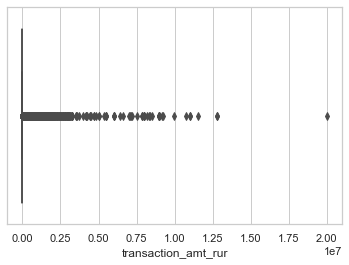

In [18]:
sns.boxplot(x=df_train['transaction_amt_rur']);

In [44]:
Q1 = df_train['transaction_amt_rur'].quantile(0.25)
Q3 = df_train['transaction_amt_rur'].quantile(0.75)
IQR = Q3 - Q1
df_train_out = df_train[~((df_train['transaction_amt_rur'] < (Q1 - 1.5 * IQR)) | (df_train['transaction_amt_rur'] > (Q3 + 1.5 * IQR)))]

In [21]:
print('Количество строк до удаления выбросов: {}, количество столбцов: {}'.format(df_train.shape[0], df_train.shape[1]))
print('Количество строк после удаления выбросов: {}, количество столбцов: {}'.format(df_train_out.shape[0], df_train_out.shape[1]))

Количество строк до удаления выбросов: 11987617, количество столбцов: 5
Количество строк после удаления выбросов: 10148296, количество столбцов: 5


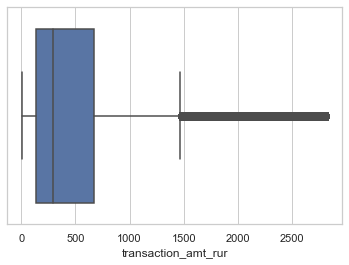

In [22]:
sns.boxplot(x=df_train_out['transaction_amt_rur']);

##### Заполнение пропусков <a class="anchor" id="ch2213"></a>

In [23]:
print("\nКоличество пропущенных значений до заполнения пропусков:")
df_train_out.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений до заполнения пропусков:


,category,transaction_amt_rur,party_rk,financial_account_type_cd,transaction_dttm
0,1235227,6,0,0,0


Для заполнения пропусков числовых переменных используются несколько методов, но мы будем использовать самый простой: в случае числового признака заменяем на среднее значение по столбцу (тк мы ранее удалили выбросы, то это среднее будет не смещенное), если это категориальный признак, то заменяем на моду. 

In [46]:
df_train_out['transaction_amt_rur'] = df_train_out['transaction_amt_rur'].fillna(df_train_out['transaction_amt_rur'].mean())

In [47]:
df_train_out['category'] = df_train_out['category'].fillna(df_train_out['category'].mode()[0])

In [34]:
print("\nКоличество пропущенных значений после заполнения пропусков:")
df_train_out.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений после заполнения пропусков:


,party_rk,financial_account_type_cd,transaction_dttm,transaction_amt_rur,category
0,0,0,0,0,0


##### Приведение категориальных признаков к числовому виду <a class="anchor" id="ch2212"></a>

Модели, которые мы будем в дальнейшем применять, работают только с числовыми признаками, поэтому приведем категориальные признаки к числовым. В основном различают 2 способа: One-hot Encoding и LabelEncoder. Второй применятся в том случае, когда мы можем выявить в данных определенный порядок, в нашем случае в столбце category ранжировать мы не можем, поэтому будем использовать One-hot Encoding.

In [39]:
# функция для перевода категориального признака в числовой через One-hot Encoding
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

In [48]:
df_train_out_num = encode_and_bind(df_train_out, 'category')

In [50]:
del df_train_out_num['category']

In [51]:
df_train_out_num

,party_rk,financial_account_type_cd,transaction_dttm,transaction_amt_rur,category_Duty Free,category_Авиабилеты,category_Автоуслуги,category_Аптеки,category_Аренда авто,category_Госсборы,...,category_Сувениры,category_Супермаркеты,category_Топливо,category_Транспорт,category_Турагентства,category_Фаст Фуд,category_Финансовые услуги,category_Фото/Видео,category_Цветы,category_Частные услуги
0,20337,1,2019-01-01,84.00,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,63404,1,2019-01-01,410.00,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,24789,2,2019-01-01,701.44,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,12232,2,2019-01-01,734.53,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,51074,2,2019-01-01,366.60,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11987612,44990,1,2019-12-31,121.00,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
11987613,53023,2,2019-12-31,102.29,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
11987614,78716,1,2019-12-31,175.00,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
11987615,73104,2,2019-12-31,185.99,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### df_socdem <a class="anchor" id="ch222"></a>

В данной таблице содержится персональная информация клиентов, где
<ul>
<li><strong>party_rk</strong> - уникальный идентификационный номер клиента</li> 
<li><strong>gender_cd</strong> - пол клиента (F - женщина / M - мужчина / не указан)</li>
<li><strong>age</strong> - возраст клиента</li>
<li><strong>marital_status_desc</strong> - семейное положение (один из 7 вариантов: Женат/замужем / Вдовец, вдова / Холост/не замужем / Гражданский брак / Разведен (а) / Не проживает с супругом (ой) / Не указано)</li>
<li><strong>children_cnt</strong> - количество детей</li>
<li><strong>region_flg</strong> - бинарная характеристика региона клиента</li>
</ul>
<strong>Первичным ключом</strong> таблицы является атрибут party_rk.

In [38]:
df_socdem.head()

,party_rk,gender_cd,age,marital_status_desc,children_cnt,region_flg
0,61243,F,70.0,NaN,0,0
1,66535,F,25.0,NaN,0,0
2,83721,M,55.0,Женат/замужем,0,0
3,88238,F,35.0,NaN,0,0
4,57179,F,30.0,Женат/замужем,0,0


##### Первичный анализ <a class="anchor" id="ch2221"></a>

In [39]:
print('Количество строк: {}, количество столбцов: {}'.format(df_socdem.shape[0], df_socdem.shape[1]))

Количество строк: 50000, количество столбцов: 6


Проверим на всякий случай, что у нас party_rk это первичный ключ. 

In [ ]:
print('Количество уникальных значений party_rk: {}'.format(len(df_socdem['party_rk'].unique())))

In [58]:
df_socdem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   party_rk             50000 non-null  int64  
 1   gender_cd            49989 non-null  object 
 2   age                  50000 non-null  float64
 3   marital_status_desc  37594 non-null  object 
 4   children_cnt         50000 non-null  int64  
 5   region_flg           50000 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 2.3+ MB


In [59]:
df_socdem.describe()

,party_rk,age,children_cnt,region_flg
count,50000.00000,50000.000000,50000.000000,50000.000000
mean,47339.73202,39.062300,0.388660,0.091900
std,27317.74524,11.675057,0.968928,0.288888
min,1.00000,15.000000,0.000000,0.000000
25%,23669.75000,30.000000,0.000000,0.000000
50%,47434.50000,35.000000,0.000000,0.000000
75%,70961.50000,45.000000,0.000000,0.000000
max,94610.00000,100.000000,4.000000,1.000000


Заметим, что максимальное значение возраста может достигать значения 100, так что, вероятно, это может быть выбросом. Проверим это в разделе "Удаление выбросов". 

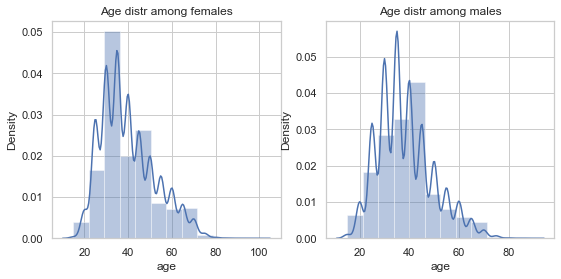

In [63]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))

female = df_socdem[df_socdem['gender_cd'] == 'F']
male = df_socdem[df_socdem['gender_cd'] == 'M']

sns.distplot(female['age'], bins=12 ,ax=ax1)
sns.distplot(male['age'], bins=12, ax=ax2)

ax1.set_title('Age distr among females');
ax2.set_title('Age distr among males');

По графику можно сделать вывод, что возраст мужчин в среднем больше, чем возраст женщин. 

Добавим категориальный признак AgeGroup, позволяющий разделить всех клиентов на 6 групп в соответствии с их возрастом:

In [84]:
df_socdem.loc[(df_socdem.age < 21),  'AgeGroup'] = '0-21'
df_socdem.loc[(21 <= df_socdem.age),  'AgeGroup'] = '21-29'
df_socdem.loc[(30 <= df_socdem.age),  'AgeGroup'] = '30-40'
df_socdem.loc[(41 <= df_socdem.age),  'AgeGroup'] = '41-54'
df_socdem.loc[(54 <= df_socdem.age),  'AgeGroup'] = '55-65'
df_socdem.loc[(65 <= df_socdem.age),  'AgeGroup'] = '65+'

In [72]:
df_socdem

,party_rk,gender_cd,age,marital_status_desc,children_cnt,region_flg,AgeGroup
0,61243,F,70.0,NaN,0,0,65+
1,66535,F,25.0,NaN,0,0,21-29
2,83721,M,55.0,Женат/замужем,0,0,55-65
3,88238,F,35.0,NaN,0,0,30-40
4,57179,F,30.0,Женат/замужем,0,0,30-40
...,...,...,...,...,...,...,...
49995,54994,M,40.0,Женат/замужем,0,0,30-40
49996,63391,M,35.0,Холост/не замужем,0,0,30-40
49997,5418,F,55.0,Холост/не замужем,0,0,55-65
49998,50273,F,35.0,Женат/замужем,0,0,30-40


In [85]:
# удалим ненужный столбец
del df_socdem['age']

##### Заполнение пропусков <a class="anchor" id="ch2223"></a>

In [76]:
print("\nКоличество пропущенных значений до заполнения пропусков:")
df_socdem.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,marital_status_desc,gender_cd,party_rk,children_cnt,region_flg,AgeGroup
0,12406,11,0,0,0,0


Вместо пропущенных значений в колонках 'marital_status_desc' и 'gender_cd' запишем значение unknown, что будет означать, что пользователь не указала своего статуса или пола. 

In [86]:
df_socdem['gender_cd'] = df_socdem['gender_cd'].fillna('unknown')
df_socdem['marital_status_desc'] = df_socdem['marital_status_desc'].fillna('unknown')

In [78]:
print("\nКоличество пропущенных значений после заполнения пропусков:")
df_socdem.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений после заполнения пропусков:


,party_rk,gender_cd,marital_status_desc,children_cnt,region_flg,AgeGroup
0,0,0,0,0,0,0


##### Приведение категориальных признаков к числовому виду <a class="anchor" id="ch2222"></a>

Заменим признак AgeGroup на числовые значения с помощью LabelEncoder, так как внутри этого признака сожно выявить порядок. 

In [87]:
# AgeGroup - категориальный признак, переведем его в тип int
le_age = preprocessing.LabelEncoder()
le_age.fit(df_socdem['AgeGroup'])
df_socdem['AgeGroup'] = le_age.transform(df_socdem['AgeGroup'])

Остальные колонки 'gender_cd' и 'material_status_desc' заменим при помощи One-hot Encoding. 

In [88]:
df_socdem_num = encode_and_bind(df_socdem, 'gender_cd')
df_socdem_num_ = encode_and_bind(df_socdem_num, 'marital_status_desc')

In [90]:
del df_socdem_num_['marital_status_desc']
del df_socdem_num_['gender_cd']

In [91]:
df_socdem_num_.head()

,party_rk,children_cnt,region_flg,AgeGroup,gender_cd_F,gender_cd_M,gender_cd_unknown,marital_status_desc_unknown,"marital_status_desc_Вдовец, вдова",marital_status_desc_Гражданский брак,marital_status_desc_Женат/замужем,marital_status_desc_Не проживает с супругом (ой),marital_status_desc_Разведен (а),marital_status_desc_Холост/не замужем
0,61243,0,0,5,1,0,0,1,0,0,0,0,0,0
1,66535,0,0,1,1,0,0,1,0,0,0,0,0,0
2,83721,0,0,4,0,1,0,0,0,0,1,0,0,0
3,88238,0,0,2,1,0,0,1,0,0,0,0,0,0
4,57179,0,0,2,1,0,0,0,0,0,1,0,0,0


### df_balance <a class="anchor" id="ch223"></a>

В данной таблице содержится ежемесячная информация о изменениях баланса клиентов, где
<ul>
<li><strong>party_rk</strong> - уникальный идентификационный номер клиента</li> 
<li><strong>account_rk</strong> - уникальный идентификационный номер счета</li>
<li><strong>prev_month</strong> - дата последнего дня (t-1)-го месяца в формате ГГГГ-ММ-ДД</li>
<li><strong>cur_month</strong> - дата последнего дня t-го месяца в формате ГГГГ-ММ-ДД</li>
<li><strong>balance_chng</strong> - изменение баланса в течение периода времени [prev_month, cur_month]</li>
</ul>
<strong>Первичный ключ</strong> таблицы является составным из двух атрибутов: account_rk + prev_month.

In [92]:
df_balance.head()

,party_rk,account_rk,prev_month,cur_month,balance_chng
0,51607,55309,2018-12-31,2019-01-31,15000.0
1,59074,70471,2018-12-31,2019-01-31,0.0
2,33941,33065,2018-12-31,2019-01-31,-15000.0
3,9336,8611,2018-12-31,2019-01-31,-50000.0
4,13958,8421,2018-12-31,2019-01-31,-20000.0


##### Первичный анализ <a class="anchor" id="ch2231"></a>

In [93]:
print('Количество строк: {}, количество столбцов: {}'.format(df_balance.shape[0], df_balance.shape[1]))

Количество строк: 614434, количество столбцов: 5


In [94]:
df_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614434 entries, 0 to 614433
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   party_rk      614434 non-null  int64  
 1   account_rk    614434 non-null  int64  
 2   prev_month    612832 non-null  object 
 3   cur_month     612832 non-null  object 
 4   balance_chng  612832 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 23.4+ MB


Переведем признаки 'prev_month' и 'cur_month' в тип datetime.

In [95]:
df_balance['prev_month'] = pd.to_datetime(df_balance['prev_month'])
df_balance['cur_month'] = pd.to_datetime(df_balance['cur_month'])

In [96]:
df_balance

,party_rk,account_rk,prev_month,cur_month,balance_chng
0,51607,55309,2018-12-31,2019-01-31,15000.0
1,59074,70471,2018-12-31,2019-01-31,0.0
2,33941,33065,2018-12-31,2019-01-31,-15000.0
3,9336,8611,2018-12-31,2019-01-31,-50000.0
4,13958,8421,2018-12-31,2019-01-31,-20000.0
...,...,...,...,...,...
614429,13734,124222,NaT,NaT,NaN
614430,33502,125615,NaT,NaT,NaN
614431,8735,123871,NaT,NaT,NaN
614432,91302,122557,NaT,NaT,NaN


##### Заполнение пропусков <a class="anchor" id="ch2233"></a>

In [97]:
print("\nКоличество пропущенных значений до заполнения пропусков:")
df_balance.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений до заполнения пропусков:


,prev_month,cur_month,balance_chng,party_rk,account_rk
0,1602,1602,1602,0,0


В тех строчках, где у нас пропущенные значения 'prev_month' и 'cur_month', нет смысла вставлять туда  моду, так как мы работаем с датами.

In [98]:
df_balance = df_balance.dropna(subset=["prev_month"],axis =0)
df_balance = df_balance.dropna(subset=["cur_month"],axis = 0)

In [99]:
print("\nКоличество пропущенных значений до заполнения пропусков:")
df_balance.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений до заполнения пропусков:


,party_rk,account_rk,prev_month,cur_month,balance_chng
0,0,0,0,0,0


##### Удаление выбросов <a class="anchor" id="ch2233"></a>

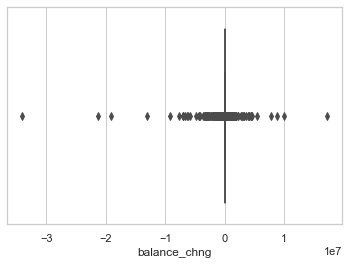

In [101]:
sns.boxplot(x=df_balance['balance_chng']);

In [102]:
Q1 = df_balance['balance_chng'].quantile(0.25)
Q3 = df_balance['balance_chng'].quantile(0.75)
IQR = Q3 - Q1
df_balance_out = df_balance[~((df_balance['balance_chng'] < (Q1 - 1.5 * IQR)) | (df_balance['balance_chng'] > (Q3 + 1.5 * IQR)))]

In [103]:
print('Количество строк до удаления выбросов: {}, количество столбцов: {}'.format(df_balance.shape[0], df_balance.shape[1]))
print('Количество строк после удаления выбросов: {}, количество столбцов: {}'.format(df_balance_out.shape[0], df_balance_out.shape[1]))

Количество строк до удаления выбросов: 612832, количество столбцов: 5
Количество строк после удаления выбросов: 466458, количество столбцов: 5


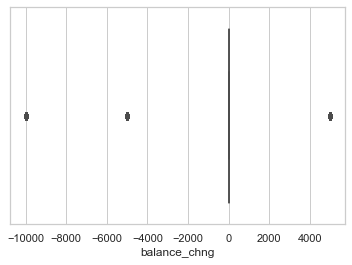

In [104]:
sns.boxplot(x=df_balance_out['balance_chng']);

In [105]:
df_balance_out.head()

,party_rk,account_rk,prev_month,cur_month,balance_chng
1,59074,70471,2018-12-31,2019-01-31,0.0
5,46840,48834,2018-12-31,2019-01-31,-5000.0
6,51748,52590,2018-12-31,2019-01-31,0.0
7,11781,8193,2018-12-31,2019-01-31,-10000.0
8,4489,3769,2018-12-31,2019-01-31,0.0


### df_stories_texts <a class="anchor" id="ch224"></a>

В данной таблице содержится информация об историях, выкладываемых Тинькоффом, где
<ul>
<li><strong>story_id</strong> - уникальный идентификационный номер истории</li> 
<li><strong>name</strong> - заголовок истории</li>
<li><strong>story_text</strong> - текст истории</li>
</ul>
<strong>Первичным ключом</strong> таблицы является атрибут story_id.

In [ ]:
df_story_texts.head()

,story_id,name,story_text
0,794,Профессия: свадебный организатор,"["""",""Как стать свадебным организатором"",""Это Л..."
1,821,Бизнес: магазин электроники,"["""",""Как открыть интернет-магазин электроники""..."
2,824,Как у них: Сингапур,"["""",""Жизнь в Сингапуре"",""Это Славина. Вместе с..."
3,839,Студии йоги,"["""",""Студии йоги"",""7 московских студий, где мо..."
4,848,Как получать больше кэшбэка,"["""",""Как получать больше кэшбэка"",""Подключите ..."


##### Первичный анализ <a class="anchor" id="ch2241"></a>

In [ ]:
print('Количество строк: {}, количество столбцов: {}'.format(df_story_texts.shape[0], df_story_texts.shape[1]))

Количество строк: 1631, количество столбцов: 3


In [ ]:
df_story_texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631 entries, 0 to 1630
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   story_id    1631 non-null   int64 
 1   name        1401 non-null   object
 2   story_text  1631 non-null   object
dtypes: int64(1), object(2)
memory usage: 38.4+ KB


##### Заполнение пропусков <a class="anchor" id="ch2243"></a>

In [106]:
print("\nКоличество пропущенных значений:")
df_story_texts.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,name,story_id,story_text
0,230,0,0


In [107]:
df_story_texts['name'] = df_story_texts['name'].fillna('Unknown')

In [108]:
print("\nКоличество пропущенных значений:")
df_story_texts.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,story_id,name,story_text
0,0,0,0


In [112]:
print('Всего топиков стори: {}'.format(df_story_texts['name'].nunique()))

Всего топиков стори: 1106


### df_stories_logs <a class="anchor" id="ch225"></a>

В данной таблице содержится информация о действиях клиентов относительно историй, где
<ul>
<li><strong>party_rk</strong> - уникальный идентификационный номер клиента</li> 
<li><strong>date_time</strong> - дата и время действия клиента в формате ГГГГ-ММ-ДД ЧЧ:ММ:СС </li>
<li><strong>story_id</strong> - уникальный идентификационный номер истории</li>
<li><strong>category</strong> - уникальный идентификационный номер категории действия</li>
<li><strong>event</strong> - наименование действия (like / dislike / ...)</li>
</ul>
<strong>Первичный ключ</strong> таблицы является составным из двух атрибутов: party_rk + date_time.

In [ ]:
df_stories_logs.head()

,party_rk,date_time,story_id,category,event
0,64266,2019-12-01 13:05:31,3840,39,like
1,55721,2019-12-01 13:18:08,3857,39,like
2,27563,2019-12-01 13:25:40,3174,78,like
3,61223,2019-12-01 13:25:20,3857,39,like
4,61223,2019-12-01 13:29:05,3765,73,like


##### Первичный анализ <a class="anchor" id="ch2251"></a>

In [ ]:
print('Количество строк: {}, количество столбцов: {}'.format(df_stories_logs.shape[0], df_stories_logs.shape[1]))

Количество строк: 13820, количество столбцов: 5


In [ ]:
df_stories_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13820 entries, 0 to 13819
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   party_rk   13820 non-null  int64 
 1   date_time  13820 non-null  object
 2   story_id   13820 non-null  int64 
 3   category   13820 non-null  int64 
 4   event      13820 non-null  object
dtypes: int64(3), object(2)
memory usage: 540.0+ KB


Заметим, что у признака 'date_time', который представляет из себя дату, тип object, хотя должен быть тип datetime.

In [113]:
df_stories_logs['date_time'] = pd.to_datetime(df_stories_logs['date_time'])

In [114]:
df_stories_logs['event'].value_counts().reset_index()

,index,event
0,like,5920
1,favorite,5028
2,dislike,763
3,14],592
4,77],551
5,153,208
6,180,108
7,177,99
8,176,72
9,54],54


Удалим строки с непонятными (числовыми) значениями по признаку 'index' 

In [115]:
df_stories_logs = df_stories_logs[(df_stories_logs['event'] == 'like') | (df_stories_logs['event'] =='dislike') | (df_stories_logs['event'] =='favorite')] 

In [116]:
df_stories_logs.head()

,party_rk,date_time,story_id,category,event
0,64266,2019-12-01 13:05:31,3840,39,like
1,55721,2019-12-01 13:18:08,3857,39,like
2,27563,2019-12-01 13:25:40,3174,78,like
3,61223,2019-12-01 13:25:20,3857,39,like
4,61223,2019-12-01 13:29:05,3765,73,like


##### Приведение категориальных признаков к числовому виду <a class="anchor" id="ch2252"></a>

In [117]:
# заменим в стобце event категориальные значение на числа
df_stories_logs['event_cat'] = np.where(df_stories_logs['event'] == 'dislike' , 0, df_stories_logs['event'])
df_stories_logs['event_cat'] = np.where(df_stories_logs['event'] == 'like' , 1, df_stories_logs['event_cat'])
df_stories_logs['event_cat'] = np.where(df_stories_logs['event'] == 'favorite' , 2, df_stories_logs['event_cat'])

In [125]:
df_stories_logs.head()

,party_rk,date_time,story_id,category,event,event_cat
0,64266,2019-12-01 13:05:31,3840,39,like,1
1,55721,2019-12-01 13:18:08,3857,39,like,1
2,27563,2019-12-01 13:25:40,3174,78,like,1
3,61223,2019-12-01 13:25:20,3857,39,like,1
4,61223,2019-12-01 13:29:05,3765,73,like,1


In [138]:
del df_stories_logs['event']

##### Заполнение пропусков <a class="anchor" id="ch2253"></a>

In [126]:
print("\nКоличество пропущенных значений:")
df_stories_logs.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,party_rk,date_time,story_id,category,event,event_cat
0,0,0,0,0,0,0


### df_products <a class="anchor" id="ch226"></a>

В данной таблице содержится информация о связи пользователей с некоторыми категориями продуктов, где
<ul>
<li><strong>party_rk</strong> - уникальный идентификационный номер клиента</li> 
<li><strong>product1 - ... - product7</strong> - связи пользователя и соответствующего продукта </li>
</ul>
<strong>Первичным ключом</strong> таблицы является атрибут party_rk.

In [127]:
df_products.head()

,party_rk,product1,product2,product3,product4,product5,product6,product7
0,74874,1,1,0,0,0,0,0
1,83618,0,0,1,1,1,0,0
2,73766,0,0,0,1,1,0,0
3,60218,0,1,0,0,0,0,0
4,47253,0,0,0,1,1,0,0


##### Первичный анализ <a class="anchor" id="ch2261"></a>

In [128]:
print('Количество строк: {}, количество столбцов: {}'.format(df_products.shape[0], df_products.shape[1]))

Количество строк: 50000, количество столбцов: 8


In [129]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   party_rk  50000 non-null  int64
 1   product1  50000 non-null  int64
 2   product2  50000 non-null  int64
 3   product3  50000 non-null  int64
 4   product4  50000 non-null  int64
 5   product5  50000 non-null  int64
 6   product6  50000 non-null  int64
 7   product7  50000 non-null  int64
dtypes: int64(8)
memory usage: 3.1 MB


Проверим, являются ли значения во всех столбцах бинарными. 

In [130]:
df_products['product1'].value_counts()

0    42582
1     7418
Name: product1, dtype: int64

In [131]:
df_products['product2'].value_counts()

1    30983
0    19017
Name: product2, dtype: int64

In [132]:
df_products['product3'].value_counts()

0    42625
1     7375
Name: product3, dtype: int64

In [133]:
df_products['product4'].value_counts()

1    32560
0    17440
Name: product4, dtype: int64

In [134]:
df_products['product5'].value_counts()

1    29704
0    20296
Name: product5, dtype: int64

In [135]:
df_products['product6'].value_counts()

0    47348
1     2652
Name: product6, dtype: int64

In [136]:
df_products['product7'].value_counts()

0    42280
1     7720
Name: product7, dtype: int64

Да, все признаки являются бинарными. 

##### Заполнение пропусков <a class="anchor" id="ch2263"></a>

In [ ]:
print("\nКоличество пропущенных значений:")
df_products.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,party_rk,product1,product2,product3,product4,product5,product6,product7
0,0,0,0,0,0,0,0,0


## Визуализация данных  <a class="anchor" id="ch4"></a>

In [ ]:
df_cluster = pd.merge(df_train, df_socdem)

In [ ]:
df_category_trans = df_cluster.groupby("category")['transaction_amt_rur'].sum().reset_index().sort_values(by = 'transaction_amt_rur', ascending = False)

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x="transaction_amt_rur", y="category", data=df_category_trans, orient = 'h');

In [ ]:
df_distr = pd.pivot_table(data = df_cluster[['age', 'transaction_amt_rur', 'children_cnt', 'gender_cd', 'category']], index = ['gender_cd', 'category'])

In [ ]:
df_distr = df_distr.reset_index()

In [ ]:
plt.figure(figsize=(16,10))
sns.lineplot(data= df_distr, x=df_distr['category'], y=df_distr['transaction_amt_rur'], hue=df_distr['gender_cd'])
plt.xticks(rotation=90);

## Feature Engineering  <a class="anchor" id="ch9"></a>

Создадим <strong> новые признаки </strong> для единой итоговой таблицы, характеризующие совершаемые клиентами транзакции в различных категориях. Новые характеристики будут отражать  
<ul>
    <li>средние траты по категориям,</li>
    <li>частоту покупок (в т.ч. повторных покупок в одной категории), </li>
    <li>статистику активности клиентов в интернете по данным категориям товаров и т.д.</li>
</ul>

### Признак №1 <a class="anchor" id="ch91"></a>

<strong>Признак:</strong> рейтинг категорий, которые лайкнул пользователь. Для того, чтобы его посчитать, смотрим на то, сколько лайков юзер поставил на стори той или иной категории и делим это на суммарное количество лайков по всем категориям. 

$\frac{\mbox{(Количество лайков у человека в конкретной категории в данном месяце)}}{\mbox{(Общее количество лайков человека в конкретном месяце)}}$

In [387]:
df_stories_logs

,party_rk,date_time,story_id,category,event_cat,Month
0,64266,2019-12-01 13:05:31,3840,39,1,12
1,55721,2019-12-01 13:18:08,3857,39,1,12
2,27563,2019-12-01 13:25:40,3174,78,1,12
3,61223,2019-12-01 13:25:20,3857,39,1,12
4,61223,2019-12-01 13:29:05,3765,73,1,12
...,...,...,...,...,...,...
13815,19043,2019-12-31 22:52:40,4117,71,1,12
13816,19043,2019-12-31 22:53:13,4120,39,1,12
13817,10195,2019-12-31 23:32:50,4117,71,2,12
13818,10195,2019-12-31 23:33:32,4120,39,1,12


In [388]:
# создадим таблицу, с количеством лайков каждого пользователя в конкректной категории
party_ids = []

for i in df_socdem_num_['party_rk'].unique():
    for j in range(55):
        party_ids.append(i)
        
a_likes = list(df_stories_logs['category'].unique()) * 50000
temple_likes = pd.DataFrame({'party_rk': party_ids, 'category': a})
df_stories_logs['Month'] = pd.DatetimeIndex(df_stories_logs['date_time']).month
df_stories_logs_likes = df_stories_logs[((df_stories_logs['Month'] == 10) | (df_stories_logs['Month'] == 11)) &
                                   (df_stories_logs['event_cat'] == 1)]
df_stories_logs_new_likes = df_stories_logs_likes.copy()
del df_stories_logs_new_likes['date_time']
del df_stories_logs_new_likes['story_id']
del df_stories_logs_new_likes['Month']
df_cat_likes = pd.DataFrame(df_stories_logs_new_likes.groupby(["party_rk", "category", 'event_cat'])['event_cat'].count())
df_cat_likes.columns = ['number_likes']
df_cat_likes.reset_index(inplace = True)
df_cat_likes_1 = pd.merge(temple_likes, df_cat_likes, how='left')
df_cat_likes_1['number_likes'] = df_cat_likes_1['number_likes'].fillna(0)
del df_cat_likes_1['event_cat']
df_cat_likes_1

,party_rk,category,number_likes
0,61243,39,0.0
1,61243,78,0.0
2,61243,73,0.0
3,61243,81,0.0
4,61243,44,0.0
...,...,...,...
2749995,77268,21,0.0
2749996,77268,64,0.0
2749997,77268,77,0.0
2749998,77268,79,0.0


In [389]:
# создадим таблицу с суммарным количеством лайков по каждому пользователю
df_cat_likes_likes_all_cat = df_cat_likes_1[['party_rk', 'number_likes']]
df_cat_likes_likes_all_cat.columns = ['party_rk', 'sum_number_likes']
df_cat_likes_likes_all_cat = df_cat_likes_likes_all_cat.groupby(['party_rk'])['sum_number_likes'].agg('sum').reset_index()
df_cat_likes_likes_all_cat

,party_rk,sum_number_likes
0,1,0.0
1,5,0.0
2,7,0.0
3,8,0.0
4,9,0.0
...,...,...
49995,94603,0.0
49996,94606,0.0
49997,94607,0.0
49998,94608,0.0


In [390]:
# создадим таблицу, где будет храниться информация о частоте лайков для каждого пользователя и категории
df_temp1_likes = pd.merge(df_cat_likes_1, df_cat_likes_likes_all_cat, how = 'left')
df_temp1_likes['freq_likes'] = 1.0 * df_temp1_likes['number_likes']/df_temp1_likes['sum_number_likes']
df_temp1_likes = df_temp1_likes[['party_rk', 'category', 'freq_likes']]
df_temp1_likes.fillna(0, inplace = True)
df_temp1_likes

,party_rk,category,freq_likes
0,61243,39,0.0
1,61243,78,0.0
2,61243,73,0.0
3,61243,81,0.0
4,61243,44,0.0
...,...,...,...
2749995,77268,21,0.0
2749996,77268,64,0.0
2749997,77268,77,0.0
2749998,77268,79,0.0


In [395]:
df_new_likes = pd.DataFrame({'party_rk': df_socdem_num_['party_rk'].unique()})
for i in df_temp1_likes['category'].unique():
    df_temp_for_likes = df_temp1_likes[df_temp1_likes['category'] == i]
    del df_temp_for_likes['category']
    df_new_likes_ = pd.merge(df_new_likes, df_temp_for_likes, left_on = 'party_rk', right_on = 'party_rk', how = 'left')
    df_new_likes = df_new_likes_.copy()

In [404]:
s_likes = ['party_rk']
for i in df_temp1_likes['category'].unique():
    string_name = 'feature1_' + str(i) 
    s_likes.append(string_name)
df_new_likes.columns = s_likes
df_new_likes_final = df_new_likes.copy()

### Признак №2 <a class="anchor" id="ch92"></a>

<strong>Признак:</strong> рейтинг категорий, которые дизлайкнул пользователь. Для того, чтобы его посчитать, смотрим на то, сколько дизлайков юзер поставил на стори той или иной категории и делим это на суммарное количество дизлайков по всем категориям. 

$\frac{\mbox{(Количество дизлайков у человека в конкретной категории в данном месяце)}}{\mbox{(Общее количество дизлайков человека в конкретном месяце)}}$

In [408]:
# создадим таблицу, с количеством дизлайков каждого пользователя в конкректной категории
a_dislikes = list(df_stories_logs['category'].unique()) * 50000
temple_dislikes = pd.DataFrame({'party_rk': party_ids, 'category': a})
df_stories_logs['Month'] = pd.DatetimeIndex(df_stories_logs['date_time']).month
df_stories_logs_dislikes = df_stories_logs[((df_stories_logs['Month'] == 10) | (df_stories_logs['Month'] == 11)) &
                                   (df_stories_logs['event_cat'] == 0)]
df_stories_logs_new_dislikes = df_stories_logs_dislikes.copy()
del df_stories_logs_new_dislikes['date_time']
del df_stories_logs_new_dislikes['story_id']
del df_stories_logs_new_dislikes['Month']
df_cat_dislikes = pd.DataFrame(df_stories_logs_new_dislikes.groupby(["party_rk", "category", 'event_cat'])['event_cat'].count())
df_cat_dislikes.columns = ['number_dislikes']
df_cat_dislikes.reset_index(inplace = True)
df_cat_dislikes_1 = pd.merge(temple_dislikes, df_cat_dislikes, how='left')
df_cat_dislikes_1['number_dislikes'] = df_cat_dislikes_1['number_dislikes'].fillna(0)
del df_cat_dislikes_1['event_cat']
df_cat_dislikes_1

,party_rk,category,number_dislikes
0,61243,39,0.0
1,61243,78,0.0
2,61243,73,0.0
3,61243,81,0.0
4,61243,44,0.0
...,...,...,...
2749995,77268,21,0.0
2749996,77268,64,0.0
2749997,77268,77,0.0
2749998,77268,79,0.0


In [410]:
# создадим таблицу с суммарным количеством дизлайков по каждому пользователю
df_cat_dislikes_dislikes_all_cat = df_cat_dislikes_1[['party_rk', 'number_dislikes']]
df_cat_dislikes_dislikes_all_cat.columns = ['party_rk', 'sum_number_dislikes']
df_cat_dislikes_dislikes_all_cat = df_cat_dislikes_dislikes_all_cat.groupby(['party_rk'])['sum_number_dislikes'].agg('sum').reset_index()
df_cat_dislikes_dislikes_all_cat

,party_rk,sum_number_dislikes
0,1,0.0
1,5,0.0
2,7,0.0
3,8,0.0
4,9,0.0
...,...,...
49995,94603,0.0
49996,94606,0.0
49997,94607,0.0
49998,94608,0.0


In [413]:
# создадим таблицу, где будет храниться информация о частоте лайков для каждого пользователя и категории
df_temp1_dislikes = pd.merge(df_cat_dislikes_1, df_cat_dislikes_dislikes_all_cat, how = 'left')
df_temp1_dislikes['freq_dislikes'] = 1.0 * df_temp1_dislikes['number_dislikes']/df_temp1_dislikes['sum_number_dislikes']
df_temp1_dislikes = df_temp1_dislikes[['party_rk', 'category', 'freq_dislikes']]
df_temp1_dislikes.fillna(0, inplace = True)
df_temp1_dislikes

,party_rk,category,freq_dislikes
0,61243,39,0.0
1,61243,78,0.0
2,61243,73,0.0
3,61243,81,0.0
4,61243,44,0.0
...,...,...,...
2749995,77268,21,0.0
2749996,77268,64,0.0
2749997,77268,77,0.0
2749998,77268,79,0.0


In [414]:
df_new_dislikes = pd.DataFrame({'party_rk': df_socdem_num_['party_rk'].unique()})
for i in df_temp1_dislikes['category'].unique():
    df_temp_for_dislikes = df_temp1_dislikes[df_temp1_dislikes['category'] == i]
    del df_temp_for_dislikes['category']
    df_new_dislikes_ = pd.merge(df_new_dislikes, df_temp_for_dislikes, left_on = 'party_rk', right_on = 'party_rk', how = 'left')
    df_new_dislikes = df_new_dislikes_.copy()

In [430]:
s_dislikes = ['party_rk']
for i in df_temp1_dislikes['category'].unique():
    string_name = 'feature2_' + str(i) 
    s_dislikes.append(string_name)
df_new_dislikes.columns = s_dislikes
df_new_dislikes_final = df_new_dislikes.copy()

In [431]:
df_new_dislikes_final.head()

,party_rk,feature2_39,feature2_78,feature2_73,feature2_81,feature2_44,feature2_16,feature2_68,feature2_15,feature2_71,...,feature2_17,feature2_72,feature2_42,feature2_1,feature2_23,feature2_21,feature2_64,feature2_77,feature2_79,feature2_75
0,61243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,83721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,88238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,57179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Признак №3 <a class="anchor" id="ch93"></a>

<strong>Признак:</strong> рейтинг категорий, которые пользователь отнес к категории 'favorites'. Для того, чтобы его посчитать, смотрим на то, сколько 'favorites' юзер поставил на стори той или иной категории и делим это на суммарное количество 'favorites' по всем категориям. 

$\frac{\mbox{(Количество 'favorites' у человека в конкретной категории в данном месяце)}}{\mbox{(Общее количество 'favorites' человека в конкретном месяце)}}$

In [419]:
# создадим таблицу, с количеством 'favorites' каждого пользователя в конкректной категории
a_favs = list(df_stories_logs['category'].unique()) * 50000
temple_favs = pd.DataFrame({'party_rk': party_ids, 'category': a})
df_stories_logs['Month'] = pd.DatetimeIndex(df_stories_logs['date_time']).month
df_stories_logs_favs = df_stories_logs[((df_stories_logs['Month'] == 10) | (df_stories_logs['Month'] == 11)) &
                                   (df_stories_logs['event_cat'] == 0)]
df_stories_logs_new_favs = df_stories_logs_favs.copy()
del df_stories_logs_new_favs['date_time']
del df_stories_logs_new_favs['story_id']
del df_stories_logs_new_favs['Month']
df_cat_favs = pd.DataFrame(df_stories_logs_new_favs.groupby(["party_rk", "category", 'event_cat'])['event_cat'].count())
df_cat_favs.columns = ['number_favs']
df_cat_favs.reset_index(inplace = True)
df_cat_favs_1 = pd.merge(temple_favs, df_cat_favs, how='left')
df_cat_favs_1['number_favs'] = df_cat_favs_1['number_favs'].fillna(0)
del df_cat_favs_1['event_cat']
df_cat_favs_1

,party_rk,category,number_favs
0,61243,39,0.0
1,61243,78,0.0
2,61243,73,0.0
3,61243,81,0.0
4,61243,44,0.0
...,...,...,...
2749995,77268,21,0.0
2749996,77268,64,0.0
2749997,77268,77,0.0
2749998,77268,79,0.0


In [421]:
# создадим таблицу с суммарным количеством 'favorites' по каждому пользователю
df_cat_favs_favs_all_cat = df_cat_favs_1[['party_rk', 'number_favs']]
df_cat_favs_favs_all_cat.columns = ['party_rk', 'sum_number_favs']
df_cat_favs_favs_all_cat = df_cat_favs_favs_all_cat.groupby(['party_rk'])['sum_number_favs'].agg('sum').reset_index()
df_cat_favs_favs_all_cat

,party_rk,sum_number_favs
0,1,0.0
1,5,0.0
2,7,0.0
3,8,0.0
4,9,0.0
...,...,...
49995,94603,0.0
49996,94606,0.0
49997,94607,0.0
49998,94608,0.0


In [422]:
# создадим таблицу, где будет храниться информация о частоте 'favorites' для каждого пользователя и категории
df_temp1_favs = pd.merge(df_cat_favs_1, df_cat_favs_favs_all_cat, how = 'left')
df_temp1_favs['freq_favs'] = 1.0 * df_temp1_favs['number_favs']/df_temp1_favs['sum_number_favs']
df_temp1_favs= df_temp1_favs[['party_rk', 'category', 'freq_favs']]
df_temp1_favs.fillna(0, inplace = True)
df_temp1_favs

,party_rk,category,freq_favs
0,61243,39,0.0
1,61243,78,0.0
2,61243,73,0.0
3,61243,81,0.0
4,61243,44,0.0
...,...,...,...
2749995,77268,21,0.0
2749996,77268,64,0.0
2749997,77268,77,0.0
2749998,77268,79,0.0


In [423]:
df_new_favs = pd.DataFrame({'party_rk': df_socdem_num_['party_rk'].unique()})
for i in df_temp1_favs['category'].unique():
    df_temp_for_favs = df_temp1_favs[df_temp1_favs['category'] == i]
    del df_temp_for_favs['category']
    df_new_favs_ = pd.merge(df_new_favs, df_temp_for_favs, left_on = 'party_rk', right_on = 'party_rk', how = 'left')
    df_new_favs = df_new_favs_.copy()

In [428]:
s_favs = ['party_rk']
for i in df_temp1_favs['category'].unique():
    string_name = 'feature3_' + str(i) 
    s_favs.append(string_name)
df_new_favs.columns = s_favs
df_new_favs_final = df_new_favs.copy()

In [429]:
df_new_favs_final.head()

,party_rk,feature3_39,feature3_78,feature3_73,feature3_81,feature3_44,feature3_16,feature3_68,feature3_15,feature3_71,...,feature3_17,feature3_72,feature3_42,feature3_1,feature3_23,feature3_21,feature3_64,feature3_77,feature3_79,feature3_75
0,61243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,83721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,88238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,57179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Признак №4 <a class="anchor" id="ch94"></a>

<strong>Признак:</strong> средняя сумма в месяц, потраченная пользователем на конкретную категорию (подсчет по последним трем месяцам).

Получим 37 новых столбцов для единой итоговой таблицы.

Укажем даты начала и конца периода из крайних трех месяцев тренировочной выборки:

In [ ]:
date1 = datetime.datetime(2019,11,30)
date4 = datetime.datetime(2019,8,31)

In [ ]:
# Функция для вывода транзакций в указанном периоде
def cutDate(start_date, stop_date):
    v1_1 = df_train[df_train['transaction_dttm'] <= stop_date]
    pre_cut = v1_1[start_date < v1_1['transaction_dttm']]
    final_cut = pre_cut['party_rk'].to_frame()
    return pre_cut, final_cut

In [ ]:
# Выпишем все party_rk всех пользователей
df_pr4 = df_socdem['party_rk'].to_frame()

# Выведем все транзакции, совершаемые в периоде времени [date4, date1]
month_3_pre_cut, month_3_final_cut  = cutDate(date4, date1)
month_3_pre_cut

In [ ]:
# Пройдем по каждой из 37 категорий и посчитаем среднюю сумму трат, сгруппированных по пользователям, 
# а затем занесем новый получившийся столбец в общую таблицу df_pr4

res4 = pd.DataFrame()
for i in range(37):
    v4_1 = month_3_pre_cut[month_3_pre_cut['category'] == i]
    v4_2 = v4_1[['party_rk', 'transaction_amt_rur']]
    feature4 = v4_2.groupby(['party_rk']).mean()
    name2 = 'feature_4_' + str(i)
    feature4 = feature4.rename(columns={'transaction_amt_rur': name2}) 
    df_pr4 = pd.merge(df_pr4, feature4, left_on='party_rk', right_on='party_rk', how='left') 

In [ ]:
# Заполним нулями все поля для пользователей, которые ничего не покупали в рассматриваемой категории за данные 3 месяца
final_feature4 = df_pr4.fillna(0)

Получаем таблицу, 37-ью столбцами которой являются категории покупок, строками - пользователи, а на перечении стоит искомый признак:

In [ ]:
final_feature4

### Признак №5 <a class="anchor" id="ch95"></a>

### Признак №6 <a class="anchor" id="ch96"></a>

### Признак №7 <a class="anchor" id="ch97"></a>

### Признак №8 <a class="anchor" id="ch98"></a>

<strong>Признак:   </strong> 
$\frac{\mbox{(Количество покупок у человека в конкретной категории в данном месяце)}}{\mbox{(Общее количество транзакций человека в конкретном месяце)}}$

Посчитаем данный признак поочередно для трёх месяцев. Получим 

$\mbox{Количество категорий}\cdot 3\mbox{ месяца} = 37\cdot3=111$ - новых столбцов для итоговой единой таблицы.

Укажем даты начала и конца крайних трех месяцев тренировочной выборки:

In [89]:
date1 = datetime.datetime(2019,11,30)
date2 = datetime.datetime(2019,10,31)
date3 = datetime.datetime(2019,9,30)
date4 = datetime.datetime(2019,8,31)

Создадим 3 датафрейма, в которых столбцом будет party_rk, а в строках будут все покупки, совершенные клиентами в
 соответствующем месяце:

In [ ]:
# Выпишем все party_rk всех пользователей
df_pr8_0 = df_socdem['party_rk'].to_frame()


# Функция для вывода транзакций в указанном периоде
def cutDate(start_date, stop_date):
    v1_1 = df_train[df_train['transaction_dttm'] <= stop_date]
    pre_cut = v1_1[start_date < v1_1['transaction_dttm']]
    final_cut = pre_cut['party_rk'].to_frame()
    return pre_cut, final_cut


# Функция для вычисления 8-ого признака
def findFeature8(pre_cut, final_cut, df_pr8, num):
    res8 = pd.DataFrame()
    for i in range(37):
        v1_4 = pre_cut[pre_cut['category'] == i]
        v1_5 = v1_4['party_rk'].to_frame()
        numerator = v1_5['party_rk'].value_counts().to_frame().reset_index()
        res8 = denominator.merge(numerator, on='index')
        feature8 = res8['party_rk_y'] / res8['party_rk_x']
        name1 = 'feature' + str(num) +'_8_' + str(i)
        res8[name1] = feature8
        fin8 = pd.DataFrame()
        fin8['party_rk'] = res8['index']
        fin8[name1] = feature8
        df_pr8 = pd.merge(df_pr8, fin8, left_on='party_rk', right_on='party_rk', how='left')
    return df_pr8

# Запустим функции для получения столбцов-признаков
pre_cut1, final_cut1 = cutDate(date2, date1)
pre_cut2, final_cut2 = cutDate(date3, date2)
pre_cut3, final_cut3 = cutDate(date4, date3)   
    
df_pr8_1 = findFeature8(pre_cut1, final_cut1, df_pr8_0, 1)
df_pr8_2 = findFeature8(pre_cut2, final_cut2, df_pr8_1, 2)
df_pr8_3 = findFeature8(pre_cut3, final_cut3, df_pr8_2, 3)


# Заполним нулями все поля, характеризующие пользователя + категорию + месяц, когда покупки вообще не совершались
final_feature8 = df_pr8_3.fillna(0)

Получаем таблицу, столбцами которой являются Один из 3 месяцев + Одна из 37 категорий, строками - пользователи, а на перечении стоит искомый признак:

In [ ]:
final_feature8

## Создание единой таблицы  <a class="anchor" id="ch10"></a>